# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_2v2:oracle.run1.framed -> cores+wisig",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "C_",
        },
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "W_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "O_",
        },
    ],
    "seed": 1337,
    "dataset_seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'O_32', 'O_20', 'O_50', 'O_38', 'O_8', 'O_44', 'O_26', 'O_14'}


{'C_2', 'W_4', 'W_3', 'C_3', 'W_1', 'C_1', 'C_4', 'W_2', 'C_5'}


tensor([[[-0.0955,  1.1942, -0.1146,  ..., -0.9840, -0.2675, -0.5732],
         [-0.6592, -0.3057,  1.0891,  ...,  0.2484, -1.4617, -0.4872]],

        [[-0.4662,  0.7090,  0.5730,  ..., -1.3014, -1.2237, -0.1165],
         [-1.1752, -0.3302,  1.1558,  ...,  0.4273, -0.1554,  1.2626]],

        [[ 0.6763, -0.3671, -0.7922,  ...,  0.8212,  1.4202,  0.3381],
         [ 0.8598,  0.7053, -0.9178,  ..., -0.7826,  0.4831, -1.1980]],

        ...,

        [[ 1.0255, -0.2498, -1.2227,  ...,  0.6639,  1.0255, -0.6771],
         [ 0.5785,  0.7428, -0.3878,  ..., -1.0123, -0.6376, -1.1701]],

        [[ 0.0260, -1.0137,  0.2924,  ...,  0.9227,  0.4808,  1.0981],
         [ 0.8122,  0.4354, -1.1631,  ..., -0.1235,  1.2996, -0.2339]],

        [[ 0.4980,  0.3408, -0.7471,  ..., -0.4718,  1.2779,  1.0616],
         [-0.4260,  1.1468, -0.0328,  ..., -1.1141, -0.0590, -0.2556]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 48.1193, train_label_loss: 2.9912, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3222.6029, train_label_loss: 1.1203, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3219.8424, train_label_loss: 0.7133, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3215.1151, train_label_loss: 0.6167, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3200.0032, train_label_loss: 0.8359, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3226.3979, train_label_loss: 0.8036, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3199.0851, train_label_loss: 0.6302, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3208.2295, train_label_loss: 0.3698, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3208.3134, train_label_loss: 0.6556, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3215.2170, train_label_loss: 0.3985, 


epoch: 1, source_val_acc_label: 0.6779, target_val_acc_label: 0.5178, source_val_label_loss: 36.6281, target_val_label_loss: 951.9274, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 4.0613, train_label_loss: 39.3832, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3238.6217, train_label_loss: 0.5585, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3224.4411, train_label_loss: 0.4286, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3228.2392, train_label_loss: 1.0498, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3219.7610, train_label_loss: 0.8367, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3234.7059, train_label_loss: 0.3772, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3245.8715, train_label_loss: 0.9043, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3243.9497, train_label_loss: 0.5787, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3246.2249, train_label_loss: 0.6661, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3231.3124, train_label_loss: 0.4193, 


epoch: 2, source_val_acc_label: 0.8012, target_val_acc_label: 0.5829, source_val_label_loss: 0.5431, target_val_label_loss: 267.1844, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.0481, train_label_loss: 0.6823, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3219.7421, train_label_loss: 0.1870, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3232.0879, train_label_loss: 0.4812, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3235.7482, train_label_loss: 0.1852, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3229.0917, train_label_loss: 0.4527, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3251.3018, train_label_loss: 0.8777, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3249.0919, train_label_loss: 0.6733, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3230.8578, train_label_loss: 0.2493, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3239.7747, train_label_loss: 0.3230, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3254.8814, train_label_loss: 0.0766, 


epoch: 3, source_val_acc_label: 0.8436, target_val_acc_label: 0.5919, source_val_label_loss: 0.4337, target_val_label_loss: 408.0688, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 4.0197, train_label_loss: 0.1560, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2990.0846, train_label_loss: 0.1316, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3118.9057, train_label_loss: 0.8470, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3113.7206, train_label_loss: 0.5414, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3077.7920, train_label_loss: 0.6132, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3114.6693, train_label_loss: 0.2544, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3202.7185, train_label_loss: 0.6752, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3173.1353, train_label_loss: 0.5017, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3136.4720, train_label_loss: 0.2471, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3168.4910, train_label_loss: 0.3156, 


epoch: 4, source_val_acc_label: 0.8485, target_val_acc_label: 0.5870, source_val_label_loss: 0.4213, target_val_label_loss: 536.4941, 


epoch: 5, [batch: 1 / 6720], examples_per_second: 3.9395, train_label_loss: 0.1358, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3140.1812, train_label_loss: 0.1518, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3142.2760, train_label_loss: 0.5451, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3077.8352, train_label_loss: 0.6237, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3194.4388, train_label_loss: 0.2363, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3191.8172, train_label_loss: 0.1027, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3167.7186, train_label_loss: 0.2101, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3116.7421, train_label_loss: 0.1257, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3151.1900, train_label_loss: 0.4979, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3165.8705, train_label_loss: 0.3067, 


epoch: 5, source_val_acc_label: 0.8465, target_val_acc_label: 0.5997, source_val_label_loss: 0.4223, target_val_label_loss: 537.9591, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 3.9687, train_label_loss: 0.2622, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3165.6617, train_label_loss: 0.6102, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3131.2466, train_label_loss: 0.4411, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3142.3948, train_label_loss: 0.1162, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3179.2441, train_label_loss: 0.1175, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3173.9723, train_label_loss: 0.1457, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3187.1728, train_label_loss: 0.5048, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3119.4049, train_label_loss: 0.2970, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3174.8045, train_label_loss: 0.2958, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3155.4907, train_label_loss: 0.0696, 


epoch: 6, source_val_acc_label: 0.8832, target_val_acc_label: 0.6091, source_val_label_loss: 0.3221, target_val_label_loss: 579.3970, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 3.9313, train_label_loss: 0.0638, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3114.0444, train_label_loss: 0.5206, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3109.0229, train_label_loss: 0.1350, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3200.3783, train_label_loss: 0.3060, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3190.1031, train_label_loss: 0.5395, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3200.8593, train_label_loss: 0.7545, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3205.4204, train_label_loss: 0.1085, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3200.7241, train_label_loss: 0.2109, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3211.1808, train_label_loss: 0.1884, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3203.0722, train_label_loss: 0.1856, 


epoch: 7, source_val_acc_label: 0.8734, target_val_acc_label: 0.6138, source_val_label_loss: 0.3421, target_val_label_loss: 664.8533, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 3.9709, train_label_loss: 0.4050, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3149.2050, train_label_loss: 0.4907, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3185.9122, train_label_loss: 0.4239, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3164.1782, train_label_loss: 0.0794, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3178.6784, train_label_loss: 0.0802, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3064.6922, train_label_loss: 0.3576, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3140.7280, train_label_loss: 0.4316, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3083.7481, train_label_loss: 0.2996, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3202.4061, train_label_loss: 0.1884, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3145.2751, train_label_loss: 0.2514, 


epoch: 8, source_val_acc_label: 0.8960, target_val_acc_label: 0.6094, source_val_label_loss: 0.2872, target_val_label_loss: 729.3325, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 3.9542, train_label_loss: 0.1161, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3181.4489, train_label_loss: 0.4918, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3174.9634, train_label_loss: 0.4039, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3145.9834, train_label_loss: 0.1754, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3112.8719, train_label_loss: 0.2049, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3045.9069, train_label_loss: 0.3784, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3169.0144, train_label_loss: 0.3970, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3141.4939, train_label_loss: 0.0765, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3157.7384, train_label_loss: 0.1611, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3097.9434, train_label_loss: 0.0968, 


epoch: 9, source_val_acc_label: 0.8898, target_val_acc_label: 0.6194, source_val_label_loss: 0.3008, target_val_label_loss: 755.0346, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 3.9875, train_label_loss: 0.2929, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3161.8571, train_label_loss: 0.2354, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3189.0571, train_label_loss: 0.3079, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3211.6794, train_label_loss: 0.2016, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3192.4482, train_label_loss: 0.1308, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3206.3252, train_label_loss: 0.1413, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3223.1878, train_label_loss: 0.1717, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3208.4254, train_label_loss: 0.2228, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3216.4868, train_label_loss: 0.2325, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3229.2926, train_label_loss: 0.0274, 


epoch: 10, source_val_acc_label: 0.9055, target_val_acc_label: 0.6119, source_val_label_loss: 0.2626, target_val_label_loss: 791.4147, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 4.0437, train_label_loss: 0.2370, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3194.3186, train_label_loss: 0.2231, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3191.0233, train_label_loss: 0.2660, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3213.5931, train_label_loss: 0.2041, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3214.1209, train_label_loss: 0.5593, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3180.4647, train_label_loss: 0.2988, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3140.8899, train_label_loss: 0.2333, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3110.0304, train_label_loss: 0.0360, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3167.0884, train_label_loss: 0.2894, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3101.3723, train_label_loss: 0.1363, 


epoch: 11, source_val_acc_label: 0.9051, target_val_acc_label: 0.6199, source_val_label_loss: 0.2687, target_val_label_loss: 878.6256, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 3.8861, train_label_loss: 0.3182, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3182.9450, train_label_loss: 0.3743, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3189.4218, train_label_loss: 0.0724, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3147.3446, train_label_loss: 0.2883, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3020.4398, train_label_loss: 0.0730, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3161.3667, train_label_loss: 0.3119, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3117.8755, train_label_loss: 0.1458, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3189.7892, train_label_loss: 0.1322, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3044.5062, train_label_loss: 0.0487, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3122.7574, train_label_loss: 0.1530, 


epoch: 12, source_val_acc_label: 0.9035, target_val_acc_label: 0.6166, source_val_label_loss: 0.2709, target_val_label_loss: 1023.0672, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 3.9279, train_label_loss: 0.3088, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3157.3870, train_label_loss: 0.1469, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3131.3118, train_label_loss: 0.1155, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3106.7326, train_label_loss: 0.3200, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3122.8459, train_label_loss: 0.0436, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3142.8010, train_label_loss: 0.3894, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3153.3793, train_label_loss: 0.2678, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3146.7493, train_label_loss: 0.0134, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3171.5413, train_label_loss: 0.0812, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3139.3082, train_label_loss: 0.1041, 


epoch: 13, source_val_acc_label: 0.9105, target_val_acc_label: 0.6307, source_val_label_loss: 0.2561, target_val_label_loss: 1054.6461, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 3.9103, train_label_loss: 0.0985, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3155.9954, train_label_loss: 0.2748, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3173.2586, train_label_loss: 0.0539, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3114.7736, train_label_loss: 0.1517, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3095.1965, train_label_loss: 0.1364, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3135.4677, train_label_loss: 0.0641, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3146.6449, train_label_loss: 0.2607, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3146.3974, train_label_loss: 0.1373, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3154.3214, train_label_loss: 0.1391, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3179.9049, train_label_loss: 0.0274, 


epoch: 14, source_val_acc_label: 0.9083, target_val_acc_label: 0.6296, source_val_label_loss: 0.2642, target_val_label_loss: 1084.7893, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 3.9362, train_label_loss: 0.0417, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3128.0490, train_label_loss: 0.0103, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3175.8760, train_label_loss: 0.0497, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3190.0374, train_label_loss: 0.1554, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3152.1059, train_label_loss: 0.1884, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3083.3342, train_label_loss: 0.0928, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3220.3935, train_label_loss: 0.1294, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3206.4525, train_label_loss: 0.1264, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3218.1427, train_label_loss: 0.1065, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3213.2638, train_label_loss: 0.0942, 


epoch: 15, source_val_acc_label: 0.9076, target_val_acc_label: 0.6337, source_val_label_loss: 0.2632, target_val_label_loss: 1182.7787, 


New best


epoch: 16, [batch: 1 / 6720], examples_per_second: 4.0007, train_label_loss: 0.0662, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3143.6266, train_label_loss: 0.1370, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3182.9932, train_label_loss: 0.0293, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3195.1309, train_label_loss: 0.0141, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3153.2679, train_label_loss: 0.1470, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3185.0845, train_label_loss: 0.1262, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3180.3490, train_label_loss: 0.2320, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3183.5993, train_label_loss: 0.1479, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3215.0262, train_label_loss: 0.0687, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3142.4383, train_label_loss: 0.0384, 


epoch: 16, source_val_acc_label: 0.8938, target_val_acc_label: 0.6391, source_val_label_loss: 0.3118, target_val_label_loss: 1209.0244, 


New best


epoch: 17, [batch: 1 / 6720], examples_per_second: 3.9891, train_label_loss: 0.0603, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3146.8324, train_label_loss: 0.1826, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3185.9865, train_label_loss: 0.0096, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3128.0220, train_label_loss: 0.1706, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3049.2147, train_label_loss: 0.0754, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 3195.1760, train_label_loss: 0.2189, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 3185.0875, train_label_loss: 0.2297, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 3170.3130, train_label_loss: 0.0235, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3185.5988, train_label_loss: 0.0819, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3191.1533, train_label_loss: 0.0364, 


epoch: 17, source_val_acc_label: 0.9098, target_val_acc_label: 0.6388, source_val_label_loss: 0.2691, target_val_label_loss: 1236.2594, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 3.9591, train_label_loss: 0.0343, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 3125.7497, train_label_loss: 0.0954, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 3199.4608, train_label_loss: 0.1176, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 3187.0053, train_label_loss: 0.0613, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 3222.8889, train_label_loss: 0.2554, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 3187.6347, train_label_loss: 0.0692, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 3168.4250, train_label_loss: 0.0130, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 3155.9626, train_label_loss: 0.0255, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 3154.0468, train_label_loss: 0.0482, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 3134.2419, train_label_loss: 0.3117, 


epoch: 18, source_val_acc_label: 0.9073, target_val_acc_label: 0.6362, source_val_label_loss: 0.2807, target_val_label_loss: 1275.6239, 


epoch: 19, [batch: 1 / 6720], examples_per_second: 3.9342, train_label_loss: 0.2513, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 3146.1683, train_label_loss: 0.0659, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 3154.8991, train_label_loss: 0.0172, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 3209.5925, train_label_loss: 0.2678, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 3183.7169, train_label_loss: 0.0596, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 3133.3904, train_label_loss: 0.0204, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 3134.9972, train_label_loss: 0.0185, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 3145.1986, train_label_loss: 0.1103, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 3140.8879, train_label_loss: 0.0098, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 3182.3100, train_label_loss: 0.2105, 


epoch: 19, source_val_acc_label: 0.9085, target_val_acc_label: 0.6536, source_val_label_loss: 0.2785, target_val_label_loss: 1479.5283, 


New best


epoch: 20, [batch: 1 / 6720], examples_per_second: 3.8788, train_label_loss: 0.1182, 


epoch: 20, [batch: 672 / 6720], examples_per_second: 3157.0948, train_label_loss: 0.0275, 


epoch: 20, [batch: 1344 / 6720], examples_per_second: 3149.3927, train_label_loss: 0.0130, 


epoch: 20, [batch: 2016 / 6720], examples_per_second: 3141.6096, train_label_loss: 0.1681, 


epoch: 20, [batch: 2688 / 6720], examples_per_second: 3126.8955, train_label_loss: 0.1186, 


epoch: 20, [batch: 3360 / 6720], examples_per_second: 3192.3743, train_label_loss: 0.0081, 


epoch: 20, [batch: 4032 / 6720], examples_per_second: 3154.0128, train_label_loss: 0.2042, 


epoch: 20, [batch: 4704 / 6720], examples_per_second: 3153.9833, train_label_loss: 0.3415, 


epoch: 20, [batch: 5376 / 6720], examples_per_second: 3187.8058, train_label_loss: 0.2590, 


epoch: 20, [batch: 6048 / 6720], examples_per_second: 3187.5033, train_label_loss: 0.0698, 


epoch: 20, source_val_acc_label: 0.9116, target_val_acc_label: 0.6541, source_val_label_loss: 0.2681, target_val_label_loss: 1384.7662, 


New best


epoch: 21, [batch: 1 / 6720], examples_per_second: 3.9428, train_label_loss: 0.1586, 


epoch: 21, [batch: 672 / 6720], examples_per_second: 3158.1249, train_label_loss: 0.0799, 


epoch: 21, [batch: 1344 / 6720], examples_per_second: 3163.6832, train_label_loss: 0.0486, 


epoch: 21, [batch: 2016 / 6720], examples_per_second: 3166.4902, train_label_loss: 0.2647, 


epoch: 21, [batch: 2688 / 6720], examples_per_second: 3188.2694, train_label_loss: 0.2501, 


epoch: 21, [batch: 3360 / 6720], examples_per_second: 3199.2682, train_label_loss: 0.1056, 


epoch: 21, [batch: 4032 / 6720], examples_per_second: 3190.1341, train_label_loss: 0.0307, 


epoch: 21, [batch: 4704 / 6720], examples_per_second: 3181.2928, train_label_loss: 0.1351, 


epoch: 21, [batch: 5376 / 6720], examples_per_second: 3210.4860, train_label_loss: 0.1557, 


epoch: 21, [batch: 6048 / 6720], examples_per_second: 3223.1854, train_label_loss: 0.2419, 


epoch: 21, source_val_acc_label: 0.9035, target_val_acc_label: 0.6467, source_val_label_loss: 0.2921, target_val_label_loss: 1417.5729, 


epoch: 22, [batch: 1 / 6720], examples_per_second: 3.9650, train_label_loss: 0.0285, 


epoch: 22, [batch: 672 / 6720], examples_per_second: 3186.9901, train_label_loss: 0.0045, 


epoch: 22, [batch: 1344 / 6720], examples_per_second: 3191.0202, train_label_loss: 0.0766, 


epoch: 22, [batch: 2016 / 6720], examples_per_second: 3165.2689, train_label_loss: 0.0478, 


epoch: 22, [batch: 2688 / 6720], examples_per_second: 3180.5705, train_label_loss: 0.0209, 


epoch: 22, [batch: 3360 / 6720], examples_per_second: 3156.6751, train_label_loss: 0.0269, 


epoch: 22, [batch: 4032 / 6720], examples_per_second: 3182.9730, train_label_loss: 0.1703, 


epoch: 22, [batch: 4704 / 6720], examples_per_second: 3137.1258, train_label_loss: 0.0353, 


epoch: 22, [batch: 5376 / 6720], examples_per_second: 3180.5611, train_label_loss: 0.1793, 


epoch: 22, [batch: 6048 / 6720], examples_per_second: 3153.9377, train_label_loss: 0.1207, 


epoch: 22, source_val_acc_label: 0.9066, target_val_acc_label: 0.6496, source_val_label_loss: 0.2905, target_val_label_loss: 1528.7059, 


epoch: 23, [batch: 1 / 6720], examples_per_second: 3.8436, train_label_loss: 0.1546, 


epoch: 23, [batch: 672 / 6720], examples_per_second: 3107.7813, train_label_loss: 0.0417, 


epoch: 23, [batch: 1344 / 6720], examples_per_second: 3119.9787, train_label_loss: 0.1096, 


epoch: 23, [batch: 2016 / 6720], examples_per_second: 3152.0519, train_label_loss: 0.1322, 


epoch: 23, [batch: 2688 / 6720], examples_per_second: 3161.4255, train_label_loss: 0.1315, 


epoch: 23, [batch: 3360 / 6720], examples_per_second: 3122.7922, train_label_loss: 0.0609, 


epoch: 23, [batch: 4032 / 6720], examples_per_second: 3176.6656, train_label_loss: 0.1104, 


epoch: 23, [batch: 4704 / 6720], examples_per_second: 3142.3607, train_label_loss: 0.0182, 


epoch: 23, [batch: 5376 / 6720], examples_per_second: 3128.9583, train_label_loss: 0.0058, 


epoch: 23, [batch: 6048 / 6720], examples_per_second: 3152.7450, train_label_loss: 0.0519, 


epoch: 23, source_val_acc_label: 0.9094, target_val_acc_label: 0.6486, source_val_label_loss: 0.2855, target_val_label_loss: 1586.0393, 


epoch: 24, [batch: 1 / 6720], examples_per_second: 3.9509, train_label_loss: 0.0087, 


epoch: 24, [batch: 672 / 6720], examples_per_second: 3140.6366, train_label_loss: 0.0805, 


epoch: 24, [batch: 1344 / 6720], examples_per_second: 3159.1367, train_label_loss: 0.0749, 


epoch: 24, [batch: 2016 / 6720], examples_per_second: 3184.3944, train_label_loss: 0.1298, 


epoch: 24, [batch: 2688 / 6720], examples_per_second: 3169.5001, train_label_loss: 0.0065, 


epoch: 24, [batch: 3360 / 6720], examples_per_second: 3206.7904, train_label_loss: 0.1033, 


epoch: 24, [batch: 4032 / 6720], examples_per_second: 3180.5044, train_label_loss: 0.1344, 


epoch: 24, [batch: 4704 / 6720], examples_per_second: 3173.2365, train_label_loss: 0.0068, 


epoch: 24, [batch: 5376 / 6720], examples_per_second: 3210.9796, train_label_loss: 0.2725, 


epoch: 24, [batch: 6048 / 6720], examples_per_second: 3177.4851, train_label_loss: 0.0515, 


epoch: 24, source_val_acc_label: 0.9083, target_val_acc_label: 0.6560, source_val_label_loss: 0.2982, target_val_label_loss: 1694.1758, 


New best


epoch: 25, [batch: 1 / 6720], examples_per_second: 3.9529, train_label_loss: 0.1486, 


epoch: 25, [batch: 672 / 6720], examples_per_second: 3176.6122, train_label_loss: 0.1101, 


epoch: 25, [batch: 1344 / 6720], examples_per_second: 3175.4692, train_label_loss: 0.1047, 


epoch: 25, [batch: 2016 / 6720], examples_per_second: 3126.1985, train_label_loss: 0.0751, 


epoch: 25, [batch: 2688 / 6720], examples_per_second: 3168.4157, train_label_loss: 0.0840, 


epoch: 25, [batch: 3360 / 6720], examples_per_second: 3161.9371, train_label_loss: 0.0325, 


epoch: 25, [batch: 4032 / 6720], examples_per_second: 3222.8290, train_label_loss: 0.1558, 


epoch: 25, [batch: 4704 / 6720], examples_per_second: 3235.6213, train_label_loss: 0.0705, 


epoch: 25, [batch: 5376 / 6720], examples_per_second: 3202.0343, train_label_loss: 0.1611, 


epoch: 25, [batch: 6048 / 6720], examples_per_second: 3075.3141, train_label_loss: 0.0234, 


epoch: 25, source_val_acc_label: 0.9051, target_val_acc_label: 0.6376, source_val_label_loss: 0.3053, target_val_label_loss: 1691.0861, 


epoch: 26, [batch: 1 / 6720], examples_per_second: 3.9126, train_label_loss: 0.0565, 


epoch: 26, [batch: 672 / 6720], examples_per_second: 3144.0745, train_label_loss: 0.3270, 


epoch: 26, [batch: 1344 / 6720], examples_per_second: 3074.8313, train_label_loss: 0.3854, 


epoch: 26, [batch: 2016 / 6720], examples_per_second: 3131.0765, train_label_loss: 0.1088, 


epoch: 26, [batch: 2688 / 6720], examples_per_second: 3151.3716, train_label_loss: 0.1929, 


epoch: 26, [batch: 3360 / 6720], examples_per_second: 3177.1781, train_label_loss: 0.0709, 


epoch: 26, [batch: 4032 / 6720], examples_per_second: 3184.3149, train_label_loss: 0.1401, 


epoch: 26, [batch: 4704 / 6720], examples_per_second: 3126.1433, train_label_loss: 0.1001, 


epoch: 26, [batch: 5376 / 6720], examples_per_second: 3146.9469, train_label_loss: 0.1725, 


epoch: 26, [batch: 6048 / 6720], examples_per_second: 3158.5979, train_label_loss: 0.0997, 


epoch: 26, source_val_acc_label: 0.9109, target_val_acc_label: 0.6525, source_val_label_loss: 0.3004, target_val_label_loss: 1777.9274, 


epoch: 27, [batch: 1 / 6720], examples_per_second: 3.9067, train_label_loss: 0.0076, 


epoch: 27, [batch: 672 / 6720], examples_per_second: 3151.3432, train_label_loss: 0.0057, 


epoch: 27, [batch: 1344 / 6720], examples_per_second: 3116.4459, train_label_loss: 0.0666, 


epoch: 27, [batch: 2016 / 6720], examples_per_second: 3115.5325, train_label_loss: 0.6314, 


epoch: 27, [batch: 2688 / 6720], examples_per_second: 3174.2720, train_label_loss: 0.0467, 


epoch: 27, [batch: 3360 / 6720], examples_per_second: 3196.6213, train_label_loss: 0.1353, 


epoch: 27, [batch: 4032 / 6720], examples_per_second: 3194.7085, train_label_loss: 0.0056, 


epoch: 27, [batch: 4704 / 6720], examples_per_second: 3198.9827, train_label_loss: 0.0890, 


epoch: 27, [batch: 5376 / 6720], examples_per_second: 3195.6772, train_label_loss: 0.0820, 


epoch: 27, [batch: 6048 / 6720], examples_per_second: 3156.7775, train_label_loss: 0.0379, 


epoch: 27, source_val_acc_label: 0.9047, target_val_acc_label: 0.6473, source_val_label_loss: 0.3090, target_val_label_loss: 1768.7552, 


epoch: 28, [batch: 1 / 6720], examples_per_second: 3.9331, train_label_loss: 0.1049, 


epoch: 28, [batch: 672 / 6720], examples_per_second: 3126.3657, train_label_loss: 0.0238, 


epoch: 28, [batch: 1344 / 6720], examples_per_second: 3156.2344, train_label_loss: 0.0336, 


epoch: 28, [batch: 2016 / 6720], examples_per_second: 3159.5119, train_label_loss: 0.0163, 


epoch: 28, [batch: 2688 / 6720], examples_per_second: 3164.8685, train_label_loss: 0.2063, 


epoch: 28, [batch: 3360 / 6720], examples_per_second: 3097.9347, train_label_loss: 0.1467, 


epoch: 28, [batch: 4032 / 6720], examples_per_second: 3136.9974, train_label_loss: 0.0127, 


epoch: 28, [batch: 4704 / 6720], examples_per_second: 3185.8722, train_label_loss: 0.0135, 


epoch: 28, [batch: 5376 / 6720], examples_per_second: 3200.7711, train_label_loss: 0.0360, 


epoch: 28, [batch: 6048 / 6720], examples_per_second: 3196.1602, train_label_loss: 0.0321, 


epoch: 28, source_val_acc_label: 0.9088, target_val_acc_label: 0.6482, source_val_label_loss: 0.3047, target_val_label_loss: 1853.9819, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

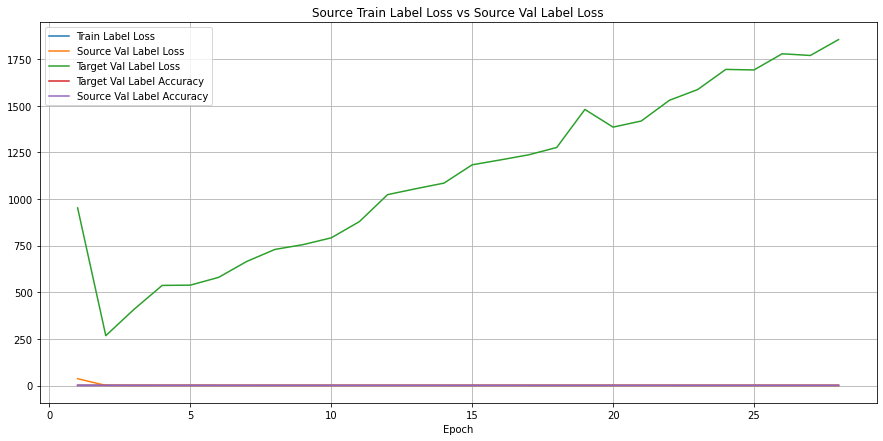

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

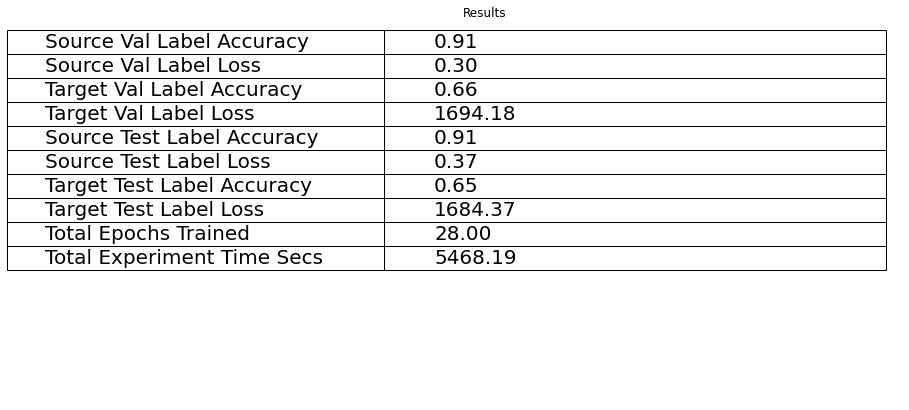

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

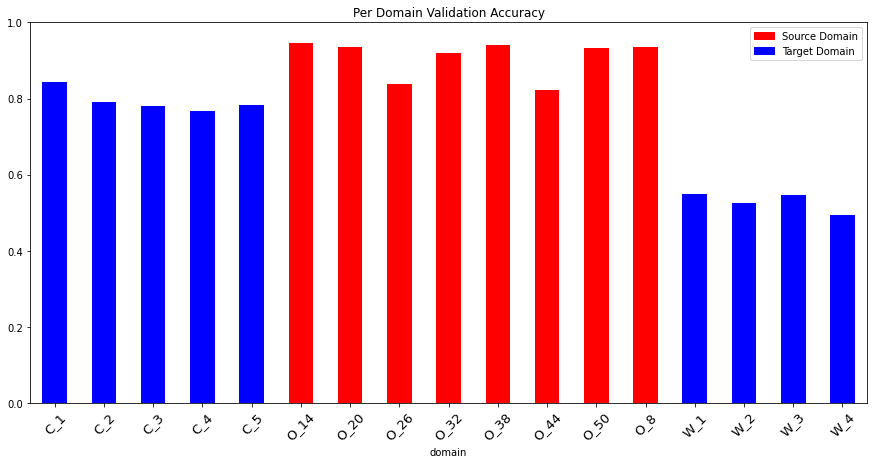

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.90927734375 Target Test Label Accuracy: 0.6488911290322581
Source Val Label Accuracy: 0.9082682291666667 Target Val Label Accuracy: 0.6559752747252747


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_2v2:oracle.run1.framed -> cores+wisig", "parameters": {"experiment_name": "tl_2v2:oracle.run1.framed -> cores+wisig", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_